In [18]:

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import neurokit2 as nk
import scipy.signal as signal
import torch
import torch.nn as nn
import neurokit2 as nk
import tensorflow as tf
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary
from torch.utils.data import Subset


In [ ]:
# carga el documento que debe tener el formato indicado para funcionar
# luego normaliza con valores entre -1 y 1
# filtra las seniales que se consideran ruido

def cargar_y_filtrar(input_file, fs, lowcut=0.5, highcut=40.0, notch_freq=50.0, Q=30.0, order=4):
    df = pd.read_csv(input_file, sep=';', parse_dates=['Timestamp'])
    signal_raw = df['ECG_Value'].values.astype(np.float32)

    b, a = signal.butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    signal_filtered = signal.filtfilt(b, a, signal_raw)

    b_notch, a_notch = signal.iirnotch(notch_freq, Q, fs)
    
    signal_filtered = signal.filtfilt(b_notch, a_notch, signal_filtered)
    scaler = MinMaxScaler(feature_range=(0, 1))
    signal_normalizada = scaler.fit_transform(signal_filtered.reshape(-1, 1)).flatten()    
    
    joblib.dump(scaler, "minmaxscaler.pkl")
    
    return df, signal_normalizada

def detectar_r_peaks(signal_filtered, fs):
    signals, info = nk.ecg_process(signal_filtered, sampling_rate=fs)
    r_peaks = info["ECG_R_Peaks"]
    return r_peaks

def guardar_con_picos(df, signal_filtered, r_peaks, output_file):      
    df['Filtered_ECG'] = signal_filtered
    df['R_Peak'] = 0
    df.loc[r_peaks, 'R_Peak'] = 1
    df.to_csv(output_file, sep=';', index=False)
    print(f"Archivo con R Peaks guardado: {output_file}")
    
def segmentar_senal(signal_filtered, segment_length, output_segments_file):
    num_segments = len(signal_filtered) // segment_length
    signal_trimmed = signal_filtered[:num_segments * segment_length]
    signal_segments = signal_trimmed.reshape(num_segments, segment_length)
    np.savetxt(output_segments_file, signal_segments, delimiter=';', fmt='%.6f', header='', comments='')
    print(f"Archivo de segmentos guardado: {output_segments_file}")
    return signal_segments    

def cargar_y_guardar_imagenes_desde_csv(csv_path, carpeta_destino='imagenes'):
    
    df = pd.read_csv(csv_path, header=None)

    señales = df.iloc[:, :187].values.astype(np.float32)
    etiquetas = df.iloc[:, 187].astype(int).values

    os.makedirs(carpeta_destino, exist_ok=True)

    for i, (senal, etiqueta) in enumerate(zip(señales, etiquetas)):

        senal = senal.reshape(-1, 1)
        senal_norm = MinMaxScaler(feature_range=(0, 1)).fit_transform(senal).flatten()

        clase_path = os.path.join(carpeta_destino, str(etiqueta))
        os.makedirs(clase_path, exist_ok=True)

        plt.figure(figsize=(1.28, 1.28), dpi=100)  
        plt.plot(senal_norm, color='black')
        plt.axis('off')
        plt.subplots_adjust(0, 0, 1, 1)
        nombre_archivo = os.path.join(clase_path, f'senal_{i:05d}.png')
        plt.savefig(nombre_archivo, bbox_inches='tight', pad_inches=0)
        plt.close()

    print(f"Imágenes generadas en: {os.path.abspath(carpeta_destino)}")

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((12, 12)),                
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='imagenes_mitbih_train', transform=transform)
test_dataset = datasets.ImageFolder(root='imagenes_mitbih_test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,num_workers=8)
train_dataset = Subset(train_dataset, range(100))
test_dataset = Subset(test_dataset, range(50))

In [ ]:
input_file = '../data/mitbih_train.csv'
carpeta_imagenes = 'imagenes_mitbih_train'
fs = 125  # Frecuencia de muestreo (referencial, no se usa en este caso)
segment_length = 187  # Cantidad de muestras por latido
# # se asigna la frecuencia en hz de las ondas como las de mitbih
# fs = 125
# # cantidad de segmentos segun la cantidad del dataset
# segment_length = 187

# # carga y filtrado de los datos para quitar ruido
# df, signal_filtered = cargar_y_filtrar(input_file, fs)

# # se detectan los r peaks de las seniales
# r_peaks = detectar_r_peaks(signal_filtered, fs)

# # se genera documento con peaks asignados
# # guardar_con_picos(df, signal_filtered, r_peaks, output_file)
# # --> los picos 
# # se genera documento final con segmentos de 187 filas
# signal_segments = segmentar_senal(signal_filtered, segment_length, output_segments_file)

#cargar_y_guardar_imagenes_desde_csv(input_file, carpeta_imagenes)

In [22]:
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=5):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
#         # ACTUALIZADO para imágenes de 28x28 → 32 canales de 7x7
#         self.fc1 = nn.Linear(32 * 7 * 7, 128)
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  # 28x28 → 14x14
#         x = self.pool(F.relu(self.conv2(x)))  # 14x14 → 7x7
#         x = x.view(x.size(0), -1)             # Flatten dinámico
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

class HeartNet(nn.Module):
    def __init__(self, num_classes=7):
        # Input x is (128, 128, 1
        super(HeartNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(64, eps=0.001),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(64, eps=0.001),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(128, eps=0.001),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(128, eps=0.001),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(256, eps=0.001),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(256, eps=0.001),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        # self.classifier = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(16*16*256, 2048),
        #     nn.ELU(inplace=True),
        #     nn.BatchNorm2d(2048, eps=0.001),
        #     nn.Linear(2048, num_classes)
        #     )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 2048),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(2048, eps=0.001),
            nn.Linear(2048, num_classes)
        )

        nn.init.xavier_uniform_(self.classifier[1].weight)
        nn.init.xavier_uniform_(self.classifier[4].weight)

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)

        x = x.view(x.size(0), -1)        
        x = self.classifier(x)
        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HeartNet(num_classes=5).to(device)
summary(model, input_size=(1, 12, 12))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 12, 12]             640
               ELU-2           [-1, 64, 12, 12]               0
       BatchNorm2d-3           [-1, 64, 12, 12]             128
            Conv2d-4           [-1, 64, 12, 12]          36,928
               ELU-5           [-1, 64, 12, 12]               0
       BatchNorm2d-6           [-1, 64, 12, 12]             128
         MaxPool2d-7             [-1, 64, 6, 6]               0
            Conv2d-8            [-1, 128, 6, 6]          73,856
               ELU-9            [-1, 128, 6, 6]               0
      BatchNorm2d-10            [-1, 128, 6, 6]             256
           Conv2d-11            [-1, 128, 6, 6]         147,584
              ELU-12            [-1, 128, 6, 6]               0
      BatchNorm2d-13            [-1, 128, 6, 6]             256
        MaxPool2d-14            [-1, 12

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
train_losses = []
val_losses = []

start_time_total = time.time()


for epoch in range(epochs):
    start_time_epoch = time.time()

    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for X_batch_val, y_batch_val in test_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)
            outputs_val = model(X_batch_val)
            val_loss = criterion(outputs_val, y_batch_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    end_time_epoch = time.time()
    epoch_duration = end_time_epoch - start_time_epoch

    print(f"Epoch {epoch+1:3}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Val Loss: {avg_val_loss:.4f} - "
          f"Duration: {epoch_duration:.2f}s")

end_time_total = time.time()
print(f"\nEntrenamiento completado en {end_time_total - start_time_total:.2f} segundos.")

Epoch   1/100 - Train Loss: 0.3121 - Val Loss: 0.2314 - Duration: 82.92s
Epoch   2/100 - Train Loss: 0.1355 - Val Loss: 0.1117 - Duration: 80.41s
Epoch   3/100 - Train Loss: 0.1030 - Val Loss: 0.0928 - Duration: 80.51s
Epoch   4/100 - Train Loss: 0.0871 - Val Loss: 0.0990 - Duration: 74.38s
Epoch   5/100 - Train Loss: 0.0745 - Val Loss: 0.0891 - Duration: 71.02s
Epoch   6/100 - Train Loss: 0.0677 - Val Loss: 0.0839 - Duration: 70.83s
Epoch   7/100 - Train Loss: 0.0599 - Val Loss: 0.0815 - Duration: 70.20s
Epoch   8/100 - Train Loss: 0.0558 - Val Loss: 0.0708 - Duration: 76.93s
Epoch   9/100 - Train Loss: 0.0506 - Val Loss: 0.0819 - Duration: 76.08s
Epoch  10/100 - Train Loss: 0.0461 - Val Loss: 0.0792 - Duration: 76.61s
Epoch  11/100 - Train Loss: 0.0412 - Val Loss: 0.1135 - Duration: 73.06s
Epoch  12/100 - Train Loss: 0.0395 - Val Loss: 0.0802 - Duration: 72.69s
Epoch  13/100 - Train Loss: 0.0369 - Val Loss: 0.0765 - Duration: 72.59s
Epoch  14/100 - Train Loss: 0.0335 - Val Loss: 0.08

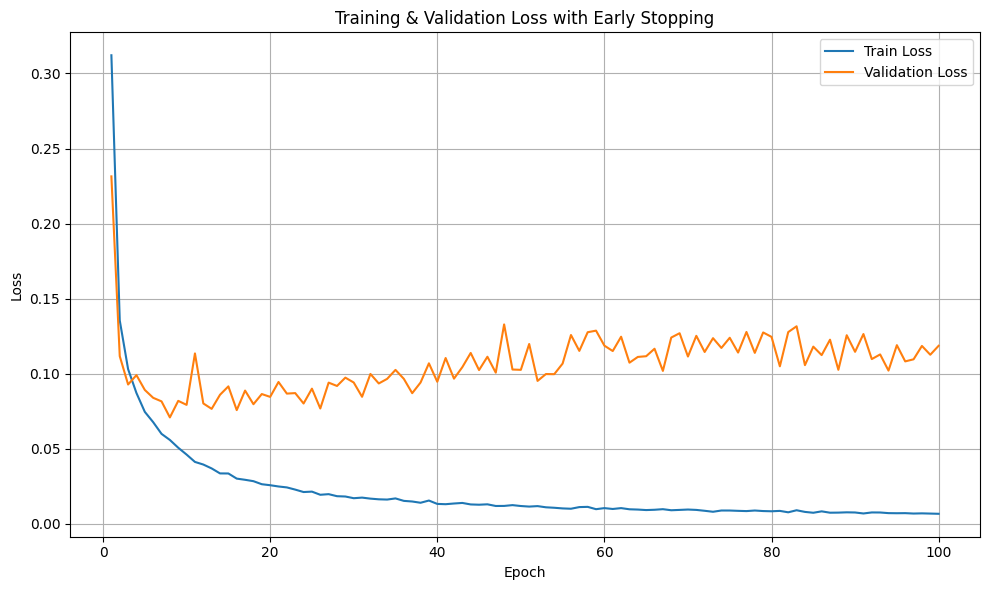

In [7]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss with Early Stopping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluando modelo...

Accuracy: 0.9817

Reporte de clasificación:

              precision    recall  f1-score   support

           0     0.9867    0.9941    0.9904     18118
           1     0.8490    0.7788    0.8124       556
           2     0.9759    0.9240    0.9493      1448
           3     0.7976    0.8272    0.8121       162
           4     0.9918    0.9795    0.9856      1608

    accuracy                         0.9817     21892
   macro avg     0.9202    0.9007    0.9100     21892
weighted avg     0.9815    0.9817    0.9815     21892



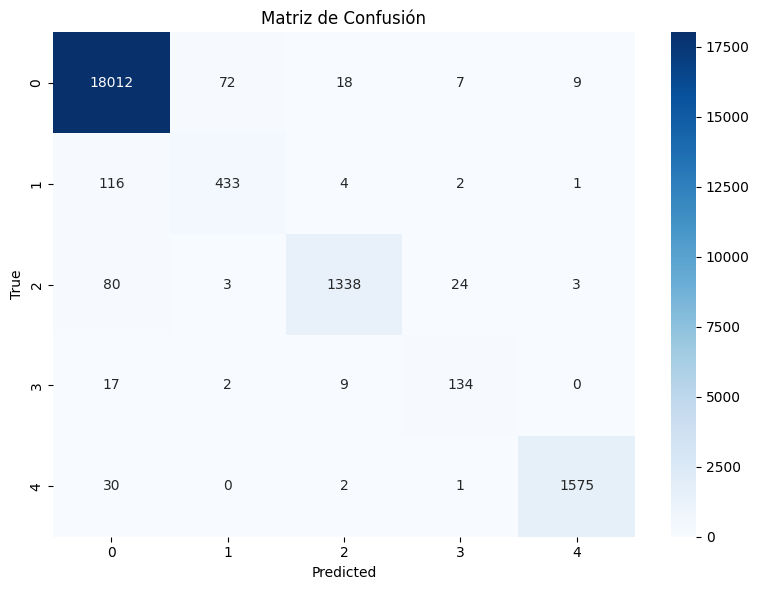


Tiempo de evaluación: 18.01 segundos
Tiempo total de ejecución: 7125.92 segundos


In [ ]:
print("\nEvaluando modelo...")

model.eval()

y_true = []
y_pred = []

eval_start_time = time.time()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

eval_time = time.time() - eval_start_time

accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\nAccuracy: {accuracy:.4f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, digits=4))

labels_unique = np.unique(np.concatenate((y_true, y_pred)))
conf_mat = confusion_matrix(y_true, y_pred, labels=labels_unique)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels_unique, yticklabels=labels_unique)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

total_time = time.time() - start_time_total
print(f"\nTiempo de evaluación: {eval_time:.2f} segundos")
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")
